# Implementation of Noise Robustness Classifiers
Advanced Machine Learning

The classification implemented are CNN with backward correction and generalized cross-entropy (GCE) loss, residual network (ResNet) with importance reweighting.

Contributors: 
- __Anh Dung Tu__
- __Jiarui Song__
- __Xiaojing Ren__




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/5328-a2

/content/drive/MyDrive/5328-a2


# 1.- Define Estimated Transition Matrix Functions

Define compute_transition_matrix, model_training_routine, freeze_model_parameters, make_predictions, estimate_transition_matrix

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
import os
from collections import OrderedDict
import copy
import torch.nn.functional as F
from torchvision import models, transforms


from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold

In [ ]:
def model_training_routine(model, data_loaders, loss_fn, optimizer, epochs=25, transition_matrix=None):
    """
    Trains the model.

    Parameters:
    - model: The model to be trained.
    - transition_matrix: The transition matrix.
    - data_loaders: Data loaders for training and validation.
    - loss_fn: Loss function.
    - optimizer: Optimizer.
    - epochs: Number of epochs.

    Returns:
    - trained_model: The trained model.
    - accuracy_history: Validation accuracy over epochs.
    """

    accuracy_history = []
    best_model_state = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    if transition_matrix is not None:
        print(f'Transition Matrix: \n{transition_matrix}\n')

    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss, running_corrects = 0.0, 0

            for data, target in data_loaders[phase]:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = loss_fn(output, target)

                    if transition_matrix is not None:
                        probabilities = F.softmax(output, dim=1)
                        probabilities = probabilities.t()
                        adjusted_output = torch.matmul(transition_matrix.t(), probabilities)
                        adjusted_output = adjusted_output.t()
                        _, predictions = torch.max(adjusted_output, 1)
                    else:
                        _, predictions = torch.max(output, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(predictions == target.data)

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_accuracy = running_corrects.double() / len(data_loaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_state = copy.deepcopy(model.state_dict())

            if phase == 'val':
                accuracy_history.append(epoch_accuracy)

        print()

    print(f'Best val Acc: {best_accuracy:4f}')
    model.load_state_dict(best_model_state)
    return model, accuracy_history

In [ ]:
def freeze_model_parameters(model, freeze=True):
    """
    Freezes or unfreezes the model parameters.

    Parameters:
    - model: The model whose parameters are to be frozen/unfrozen.
    - freeze: Whether to freeze the parameters.
    """
    for param in model.parameters():
        param.requires_grad = not freeze

In [ ]:
def make_predictions(model, loader, device, revised=False):
    """
    Makes predictions using the model.

    Parameters:
    - model: The model to be used for making predictions.
    - loader: The data loader.
    - device: The device (CPU/GPU).
    - revised: Whether to use a revised prediction method.

    Returns:
    - true_labels: The true labels.
    - predicted_labels: The predicted labels.
    - accuracy: The prediction accuracy.
    - output_probs: The output probabilities.
    """
    model.eval()

    true_labels = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)

    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)

            if revised:
                output = model(data, revised=revised)[0]
            else:
                output = model(data)

            true_labels = torch.cat((true_labels, labels), 0)
            all_outputs = torch.cat((all_outputs, output), 0)

    output_probs = F.softmax(all_outputs, dim=1)
    true_labels = true_labels.cpu().numpy()
    _, predicted_labels = torch.max(all_outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    accuracy = np.sum(true_labels == predicted_labels) / len(predicted_labels)

    return true_labels, predicted_labels, accuracy, output_probs

In [ ]:
def estimate_transition_matrix(loader, model, num_classes):
    model.eval()
    joint_distribution = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for data, targets in loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(targets.view(-1), preds.view(-1)):
                joint_distribution[t.long(), p.long()] += 1

    # Normalize to get the transition matrix
    transition_matrix = joint_distribution / joint_distribution.sum(1, keepdim=True)
    return transition_matrix

In [ ]:
def get_loader(X_train, y_train, X_test, y_test, batch_size, transform):
    # Create TensorDatasets for training, validation, and test data
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # Split training data into training and validation sets
    train_size = int(0.8 * len(train_dataset))  # Assuming an 80/20 split
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
#Acknowledgement: This function is inspired by and has components from the corresponding function in the week 10 tutorial ipynb file of COMP4328/5328 Advanced Machine Learning course at University of Sydney.
def seed_torch(seed=1029):
    r"""Fix all random seeds for repeating the expriement result."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # If multi-GPUs are used.
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, T_matrix, with_revision):
    """
    Helper function to train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for b, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        if with_revision:
            out, revision = model(inputs, revision=with_revision)
            loss = criterion(out, T_matrix, labels, revision)
        else:
            out = model(inputs)
            loss = criterion(out, T_matrix, labels)

        prob = F.softmax(out, dim=1)
        out = torch.matmul(T_matrix.t(), prob.t()) if not with_revision else torch.matmul((T_matrix + revision).t(), prob.t())
        out = out.t()

        _, preds = torch.max(out, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if with_revision and abs(loss.item() * inputs.size(0)) < 0.02:
            break

    return running_loss, running_corrects

def validate_epoch(model, dataloader, criterion, T_matrix, with_revision):
    """
    Helper function to validate the model for one epoch.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for b, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        if with_revision:
            out, revision = model(inputs, revision=with_revision)
            loss = criterion(out, T_matrix, labels, revision)
        else:
            out = model(inputs)
            loss = criterion(out, T_matrix, labels)

        prob = F.softmax(out, dim=1)
        out = torch.matmul(T_matrix.t(), prob.t()) if not with_revision else torch.matmul((T_matrix + revision).t(), prob.t())
        out = out.t()

        _, preds = torch.max(out, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

def train_model_forward(model, dataloaders, criterion, optimizer, T_matrix, with_revision=False, num_epochs=25):
    """
    Function to train the model.

    :param model: Model
    :param dataloaders: DataLoader
    :param criterion: Loss function
    :param optimizer: Optimizer
    :param with_revision: True or False
    :param num_epochs: Number of epochs
    :return model: Trained model
    """

    val_acc_history = []
    revision_evl = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training phase
        train_loss, train_corrects = train_epoch(model, dataloaders['train'], criterion, optimizer, T_matrix, with_revision)
        print_stats('train', train_loss, train_corrects, dataloaders)

        # Validation phase
        val_loss, val_corrects = validate_epoch(model, dataloaders['val'], criterion, T_matrix, with_revision)
        epoch_acc = print_stats('val', val_loss, val_corrects, dataloaders)

        if with_revision:
            revision_evl.append(revision)

        # Save the model weights if the current epoch has a better validation accuracy
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        val_acc_history.append(epoch_acc)
        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, revision_evl

def print_stats(phase, running_loss, running_corrects, dataloaders):
    """
    Helper function to print the statistics after each epoch.
    """
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return epoch_acc


#2.- Data Loading and Preprocessing

In [ ]:
# Call the seed function to set all seeds
seed_torch()

# Load CIFAR dataset
with np.load('CIFAR.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Adjust the dimensions of image data
Xtr_val = Xtr_val.permute(0, 3, 1, 2)
Xts = Xts.permute(0, 3, 1, 2)

# Setting up data loaders
train_loader, val_loader, test_loader = get_loader(X_train=Xtr_val, y_train=Str_val, X_test=Xts, y_test=Yts, batch_size=128, transform=True)
data_loaders_dict = {'train': train_loader, 'val': val_loader}

# Defining the parameters
class_count = 3
epoch_count = 10
pretrained_model_use = False
feature_extraction_flag = False

# Initializing the model
resnet_model = models.resnet18(pretrained=pretrained_model_use)

# Updating the first convolutional layer for single-channel input, if necessary
if Xtr_val.shape[1] == 1:
    resnet_model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=True)

# Setting the required gradient property of the model parameters
freeze_model_parameters(resnet_model, feature_extraction_flag)

# Updating the final fully connected layer to match the number of classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, class_count)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

# Defining the parameters to update, optimizer, and loss function
params_to_update = [param for param in resnet_model.parameters() if param.requires_grad]
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# Training and evaluating the model
trained_model, accuracy_history = model_training_routine(resnet_model, data_loaders_dict, loss_fn, optimizer_ft, epochs=epoch_count)

# Make predictions on the test set
true_labels, predicted_labels, accuracy, output_probs = make_predictions(trained_model, test_loader, device)

# Output the results
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.1659 Acc: 0.3419
val Loss: 1.1317 Acc: 0.3560

Epoch 1/9
----------
train Loss: 1.1068 Acc: 0.3859
val Loss: 1.1207 Acc: 0.3517

Epoch 2/9
----------
train Loss: 1.0623 Acc: 0.4331
val Loss: 1.1475 Acc: 0.3567

Epoch 3/9
----------
train Loss: 1.0091 Acc: 0.5005
val Loss: 1.1501 Acc: 0.3547

Epoch 4/9
----------
train Loss: 0.9269 Acc: 0.5729
val Loss: 1.1943 Acc: 0.3563

Epoch 5/9
----------
train Loss: 0.8413 Acc: 0.6288
val Loss: 1.2659 Acc: 0.3630

Epoch 6/9
----------
train Loss: 0.7380 Acc: 0.6894
val Loss: 1.3649 Acc: 0.3537

Epoch 7/9
----------
train Loss: 0.6263 Acc: 0.7468
val Loss: 1.5525 Acc: 0.3487

Epoch 8/9
----------
train Loss: 0.5059 Acc: 0.8044
val Loss: 1.6745 Acc: 0.3663

Epoch 9/9
----------
train Loss: 0.4170 Acc: 0.8420
val Loss: 1.7483 Acc: 0.3567

Best val Acc: 0.366333
Test Accuracy: 40.43%


In [ ]:
num_classes = 3
trained_model.cpu()
transition_matrix = estimate_transition_matrix(train_loader, trained_model, num_classes)
print('Estimated Transition Matrix:\n', transition_matrix)

Estimated Transition Matrix:
 tensor([[0.7945, 0.0527, 0.1528],
        [0.1472, 0.6585, 0.1943],
        [0.0799, 0.0359, 0.8842]])


##2.1- Validating the effectiveness of Transition matrix estimator - FashionMNIST0.5
We will validate the effectiveness of our estimated T matrix of the dataset `FashionMNIST0.6` by using ResNet, where the transition matrix is already provided:

$$\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.3 & 0.5 & 0.2\\
0.2 & 0.3 & 0.5
\end{bmatrix}$$

In [ ]:
# Call the seed function to set all seeds
seed_torch()

with np.load('FashionMNIST0.5.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Setting up data loaders
train_loader, val_loader, test_loader = get_loader(X_train=Xtr_val, y_train=Str_val, X_test=Xts, y_test=Yts, batch_size=128, transform=True)
data_loaders_dict = {'train': train_loader, 'val': val_loader}

# Defining the parameters
class_count = 3
epoch_count = 10
pretrained_model_use = False
feature_extraction_flag = False

# Initializing the model
resnet_model = models.resnet18(pretrained=pretrained_model_use)

# Updating the first convolutional layer for single-channel input, if necessary
if Xtr_val.shape[1] == 1:
    resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Setting the required gradient property of the model parameters
freeze_model_parameters(resnet_model, feature_extraction_flag)

# Updating the final fully connected layer to match the number of classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, class_count)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

# Defining the parameters to update, optimizer, and loss function
params_to_update = [param for param in resnet_model.parameters() if param.requires_grad]
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# Training and evaluating the model
trained_model, accuracy_history = model_training_routine(resnet_model, data_loaders_dict, loss_fn, optimizer_ft, epochs=epoch_count)

# Make predictions on the test set
true_labels, predicted_labels, accuracy, output_probs = make_predictions(trained_model, test_loader, device)

# Output the results
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 0/9
----------
train Loss: 1.1152 Acc: 0.4149
val Loss: 1.0803 Acc: 0.4450

Epoch 1/9
----------
train Loss: 1.0452 Acc: 0.4722
val Loss: 1.0780 Acc: 0.4381

Epoch 2/9
----------
train Loss: 1.0013 Acc: 0.5090
val Loss: 1.1042 Acc: 0.4200

Epoch 3/9
----------
train Loss: 0.9493 Acc: 0.5460
val Loss: 1.1142 Acc: 0.4353

Epoch 4/9
----------
train Loss: 0.9033 Acc: 0.5806
val Loss: 1.1677 Acc: 0.3933

Epoch 5/9
----------
train Loss: 0.8500 Acc: 0.6130
val Loss: 1.1866 Acc: 0.4044

Epoch 6/9
----------
train Loss: 0.7888 Acc: 0.6488
val Loss: 1.2421 Acc: 0.4075

Epoch 7/9
----------
train Loss: 0.7343 Acc: 0.6819
val Loss: 1.3910 Acc: 0.3892

Epoch 8/9
----------
train Loss: 0.6806 Acc: 0.7044
val Loss: 1.4580 Acc: 0.4056

Epoch 9/9
----------
train Loss: 0.6386 Acc: 0.7319
val Loss: 1.4487 Acc: 0.4014

Best val Acc: 0.445000
Test Accuracy: 75.73%


In [ ]:
num_classes = 3
trained_model.cpu()
transition_matrix = estimate_transition_matrix(train_loader, trained_model, num_classes)
print('Estimated Transition Matrix:\n', transition_matrix)

Estimated Transition Matrix:
 tensor([[0.5105, 0.2344, 0.2551],
        [0.2798, 0.5249, 0.1953],
        [0.2383, 0.3080, 0.4537]])


In [ ]:
# Define the new estimated transition matrix
estimated_T_new = np.array([[0.5105, 0.2344, 0.2551],
        [0.2798, 0.5249, 0.1953],
        [0.2383, 0.3080, 0.4537]])

# Define the new true transition matrix T
T_new = np.array([[0.5, 0.2, 0.3],
                  [0.3, 0.5, 0.2],
                  [0.2, 0.3, 0.5]])

# Calculate the error matrix
error_matrix_new = np.abs(estimated_T_new - T_new)

# Calculate the mean absolute error
mae_new = np.mean(error_matrix_new)

print("Mean Absolute Error for the new matrices:", mae_new)


Mean Absolute Error for the new matrices: 0.0258


##2.2- Validating the effectiveness of transition matrix estimator - FashionMNIST0.6

We will validate the effectiveness of our estimated T matrix of the dataset `FashionMNIST0.6` by using ResNet, where the transition matrix is already provided:

$$\begin{bmatrix}
0.4 & 0.3 & 0.3\\
0.3 & 0.4 & 0.3\\
0.3 & 0.3 & 0.4
\end{bmatrix}$$

In [ ]:
# Call the seed function to set all seeds
seed_torch()

with np.load('FashionMNIST0.6.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Setting up data loaders
train_loader, val_loader, test_loader = get_loader(X_train=Xtr_val, y_train=Str_val, X_test=Xts, y_test=Yts, batch_size=128, transform=True)
data_loaders_dict = {'train': train_loader, 'val': val_loader}

# Defining the parameters
class_count = 3
epoch_count = 10
pretrained_model_use = False
feature_extraction_flag = False

# Initializing the model
resnet_model = models.resnet18(pretrained=pretrained_model_use)

# Updating the first convolutional layer for single-channel input, if necessary
if Xtr_val.shape[1] == 1:
    resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Setting the required gradient property of the model parameters
freeze_model_parameters(resnet_model, feature_extraction_flag)

# Updating the final fully connected layer to match the number of classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, class_count)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

# Defining the parameters to update, optimizer, and loss function
params_to_update = [param for param in resnet_model.parameters() if param.requires_grad]
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# Training and evaluating the model
trained_model, accuracy_history = model_training_routine(resnet_model, data_loaders_dict, loss_fn, optimizer_ft, epochs=epoch_count)

# Make predictions on the test set
true_labels, predicted_labels, accuracy, output_probs = make_predictions(trained_model, test_loader, device)

# Output the results
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 0/9
----------
train Loss: 1.1582 Acc: 0.3433
val Loss: 1.1270 Acc: 0.3683

Epoch 1/9
----------
train Loss: 1.1030 Acc: 0.3841
val Loss: 1.1294 Acc: 0.3536

Epoch 2/9
----------
train Loss: 1.0606 Acc: 0.4414
val Loss: 1.1326 Acc: 0.3628

Epoch 3/9
----------
train Loss: 1.0219 Acc: 0.4848
val Loss: 1.1497 Acc: 0.3519

Epoch 4/9
----------
train Loss: 0.9656 Acc: 0.5391
val Loss: 1.1935 Acc: 0.3364

Epoch 5/9
----------
train Loss: 0.9081 Acc: 0.5739
val Loss: 1.2280 Acc: 0.3447

Epoch 6/9
----------
train Loss: 0.8588 Acc: 0.6126
val Loss: 1.3234 Acc: 0.3317

Epoch 7/9
----------
train Loss: 0.8107 Acc: 0.6397
val Loss: 1.3505 Acc: 0.3528

Epoch 8/9
----------
train Loss: 0.7598 Acc: 0.6604
val Loss: 1.4364 Acc: 0.3275

Epoch 9/9
----------
train Loss: 0.7052 Acc: 0.6908
val Loss: 1.4928 Acc: 0.3461

Best val Acc: 0.368333
Test Accuracy: 58.70%


In [ ]:
num_classes = 3
trained_model.cpu()
transition_matrix = estimate_transition_matrix(train_loader, trained_model, num_classes)
print('Estimated Transition Matrix:\n', transition_matrix)

Estimated Transition Matrix:
 tensor([[0.5269, 0.3117, 0.1614],
        [0.3771, 0.4553, 0.1675],
        [0.4076, 0.3385, 0.2540]])


In [ ]:
# Define the new estimated transition matrix
estimated_T_new = np.array([[0.5269, 0.3117, 0.1614],
        [0.3771, 0.4553, 0.1675],
        [0.4076, 0.3385, 0.2540]])

# Define the new true transition matrix T
T_new = np.array([[0.4, 0.3, 0.3],
                  [0.3, 0.4, 0.3],
                  [0.3, 0.3, 0.4]])

# Calculate the error matrix
error_matrix_new = np.abs(estimated_T_new - T_new)

# Calculate the mean absolute error
mae_new = np.mean(error_matrix_new)

print("Mean Absolute Error for the new matrices:", mae_new)


Mean Absolute Error for the new matrices: 0.09268888888888888


#3.- Backward Experiment and results

##3.1- Defining CNN model


In [ ]:
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Default dropout rate
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Change here
            nn.BatchNorm2d(32),
            nn.ReLU(), #https://colab.research.google.com/drive/1LyTSETiFqX39hifMEnDwEmZY34AN-X6u#scrollTo=Tuning_the_hyper_parameter
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layers with dropout
        self.fc1 = nn.Linear(in_features=3136, out_features=600)
        self.drop = nn.Dropout2d(dropout_rate)  # Use the dropout rate parameter
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

##3.2- Defining Backward corrected loss fucntion

In [ ]:
from torch.nn.functional import softmax
class GeneralizedCrossEntropy(nn.Module):
    def __init__(self, q=0.7, epsilon=1e-8):
        super(GeneralizedCrossEntropy, self).__init__()
        self.q = q
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        p = F.softmax(inputs, dim=1)
        Yg = torch.gather(p, 1, targets.unsqueeze(1))
        Yg = Yg.clamp(min=self.epsilon)
        loss = (1 - Yg.pow(self.q)) / self.q
        # Return the individual losses per example
        return loss

def corrected_loss(outputs, labels, transition_matrix, q1=0.7):
    # Calculate the inverse of the transition matrix
    transition_matrix_inv = torch.inverse(transition_matrix).to(outputs.device)

    # Softmax the outputs to get predicted probabilities
    softmax_outputs = softmax(outputs, dim=1)

    # Correct the predicted probabilities by multiplying with the inverse transition matrix
    # Here we use matrix multiplication
    corrected_preds = torch.matmul(softmax_outputs, transition_matrix_inv)

    # Compute the Generalized Cross Entropy loss with the corrected predictions
    gce_loss = GeneralizedCrossEntropy(q=q1)(corrected_preds, labels)

    # Mean of the losses
    corrected_mean_loss = gce_loss.mean()
    return corrected_mean_loss



#### Experiment in CIFAR

In [ ]:
seed_torch()
# Load and preprocess your data
with np.load('CIFAR.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).permute(0, 3, 1, 2)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).permute(0, 3, 1, 2)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)


# Create TensorDatasets for training and testing
train_dataset = TensorDataset(Xtr_val, Str_val)
test_dataset = TensorDataset(Xts, Yts)

# Create DataLoaders for batching and shuffling the 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


# Define the transition matrix for dealing with noisy labels
transition_matrix = torch.tensor([[0.7945, 0.0527, 0.1528],
        [0.1472, 0.6585, 0.1943],
        [0.0799, 0.0359, 0.8842]], dtype=torch.float32)

num_epochs = 5

baseline_acc_cifar = 0.48

In [ ]:
from collections import defaultdict
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
n_iters = 10  # Set the number of iterations for the whole process
mean_metrics_cifar = defaultdict(list)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for n in range(n_iters):
    print(f"\nTraining iteration: {n+1}")

    # Reset the model and optimizer for each iteration
    model = FashionCNN(dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    all_metrics = defaultdict(list)  # Reset metrics for each iteration

    # Training and Testing loops for one iteration
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix, 0.6)
            loss.backward()
            optimizer.step()

        # Evaluation loop
        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  # No transition matrix applied during testing
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics at the end of each epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Store metrics
        all_metrics['accuracy'].append(accuracy)
        all_metrics['precision'].append(precision)
        all_metrics['recall'].append(recall)
        all_metrics['f1'].append(f1)

        # Print the metrics for the current epoch
        print(f'Epoch {epoch + 1}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}')

    # Calculate and store mean metrics for the current iteration
    for metric_name, metric_values in all_metrics.items():
        mean_metric = np.mean(metric_values)
        std_metric = np.std(metric_values)
        mean_metrics_cifar[metric_name].append(mean_metric)
        print(f'Iteration {n+1} - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')


Training iteration: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.5420, Precision = 0.5718, Recall = 0.5420, F1-Score = 0.5184


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


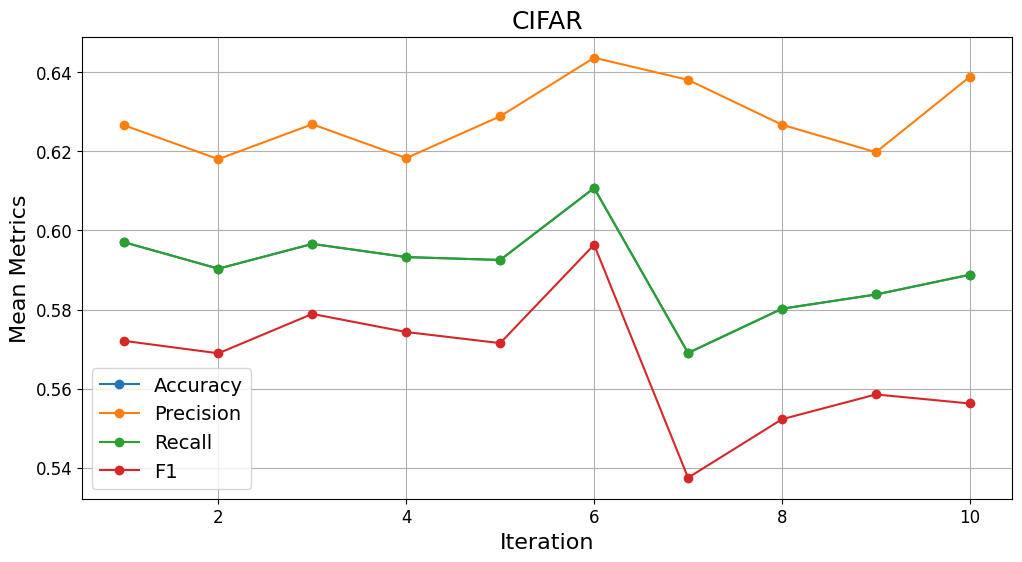

In [ ]:
# Suppose n_iters is the total number of iterations you performed
n_iters = 10

# You generate an array of iteration numbers starting from 1 to n_iters
iterations = np.arange(1, n_iters + 1)

plt.figure(figsize=(12, 6))
for metric_name, metric_values in mean_metrics_cifar.items():
    # if metric_name == "accuracy":
      plt.plot(iterations, metric_values, marker='o', label=metric_name.capitalize())
    # print(metric_name)

# Add a horizontal line for the baseline
# plt.axhline(y=baseline_acc_cifar, color='r', linestyle='--', label='Baseline')

# Set the font sizes
label_fontsize = 16
title_fontsize = 18
legend_fontsize = 14

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Mean Metrics', fontsize=label_fontsize)
plt.title('CIFAR', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Optionally, you can also increase the tick font sizes if needed
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

#### Experiment on FashionMNIST0.5

In [ ]:
# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Default dropout rate
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # Apply Dropout with 0.25 probability
        self.drop = nn.Dropout2d(dropout_rate)
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # Fully Connected Layer 3
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [ ]:
seed_torch()
with np.load('FashionMNIST0.5.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(Xtr_val, Str_val)
test_dataset = TensorDataset(Xts, Yts)

# Create DataLoaders for batching and shuffling the data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the transition matrix for dealing with noisy labels
transition_matrix = torch.tensor([[0.5, 0.2, 0.3],
                                  [0.3, 0.5, 0.2],
                                  [0.2, 0.3, 0.5]], dtype=torch.float32)

# # Train the model
num_epochs = 5


In [ ]:
n_iters = 10  # Set the number of iterations for the whole process
mean_metrics_f5 = defaultdict(list)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for n in range(n_iters):
    print(f"\nTraining iteration: {n+1}")

    # Reset the model and optimizer for each iteration
    model = FashionCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    all_metrics = defaultdict(list)  # Reset metrics for each iteration

    # Training and Testing loops for one iteration
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix, 0.7)
            loss.backward()
            optimizer.step()

        # Evaluation loop
        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  # No transition matrix applied during testing
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics at the end of each epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Store metrics
        all_metrics['accuracy'].append(accuracy)
        all_metrics['precision'].append(precision)
        all_metrics['recall'].append(recall)
        all_metrics['f1'].append(f1)

        # Print the metrics for the current epoch
        # print(f'Epoch {epoch + 1}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}')

    # Calculate and store mean metrics for the current iteration
    for metric_name, metric_values in all_metrics.items():
        mean_metric = np.mean(metric_values)
        std_metric = np.std(metric_values)
        mean_metrics_f5[metric_name].append(mean_metric)
        print(f'Iteration {n+1} - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')




Training iteration: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 1 - Accuracy Mean: 0.9219, STD: 0.0101
Iteration 1 - Precision Mean: 0.9263, STD: 0.0102
Iteration 1 - Recall Mean: 0.9219, STD: 0.0101
Iteration 1 - F1 Mean: 0.9225, STD: 0.0101

Training iteration: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 2 - Accuracy Mean: 0.9230, STD: 0.0121
Iteration 2 - Precision Mean: 0.9261, STD: 0.0101
Iteration 2 - Recall Mean: 0.9230, STD: 0.0121
Iteration 2 - F1 Mean: 0.9236, STD: 0.0119

Training iteration: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 3 - Accuracy Mean: 0.9263, STD: 0.0099
Iteration 3 - Precision Mean: 0.9298, STD: 0.0095
Iteration 3 - Recall Mean: 0.9263, STD: 0.0099
Iteration 3 - F1 Mean: 0.9268, STD: 0.0099

Training iteration: 4


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 4 - Accuracy Mean: 0.9247, STD: 0.0169
Iteration 4 - Precision Mean: 0.9279, STD: 0.0158
Iteration 4 - Recall Mean: 0.9247, STD: 0.0169
Iteration 4 - F1 Mean: 0.9254, STD: 0.0165

Training iteration: 5


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 5 - Accuracy Mean: 0.9247, STD: 0.0096
Iteration 5 - Precision Mean: 0.9283, STD: 0.0088
Iteration 5 - Recall Mean: 0.9247, STD: 0.0096
Iteration 5 - F1 Mean: 0.9253, STD: 0.0095

Training iteration: 6


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 6 - Accuracy Mean: 0.9261, STD: 0.0131
Iteration 6 - Precision Mean: 0.9298, STD: 0.0108
Iteration 6 - Recall Mean: 0.9261, STD: 0.0131
Iteration 6 - F1 Mean: 0.9267, STD: 0.0128

Training iteration: 7


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 7 - Accuracy Mean: 0.9235, STD: 0.0142
Iteration 7 - Precision Mean: 0.9282, STD: 0.0114
Iteration 7 - Recall Mean: 0.9235, STD: 0.0142
Iteration 7 - F1 Mean: 0.9243, STD: 0.0138

Training iteration: 8


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 8 - Accuracy Mean: 0.9228, STD: 0.0102
Iteration 8 - Precision Mean: 0.9252, STD: 0.0097
Iteration 8 - Recall Mean: 0.9228, STD: 0.0102
Iteration 8 - F1 Mean: 0.9233, STD: 0.0101

Training iteration: 9


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 9 - Accuracy Mean: 0.9271, STD: 0.0143
Iteration 9 - Precision Mean: 0.9304, STD: 0.0120
Iteration 9 - Recall Mean: 0.9271, STD: 0.0143
Iteration 9 - F1 Mean: 0.9277, STD: 0.0140

Training iteration: 10


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

Iteration 10 - Accuracy Mean: 0.9285, STD: 0.0108
Iteration 10 - Precision Mean: 0.9321, STD: 0.0091
Iteration 10 - Recall Mean: 0.9285, STD: 0.0108
Iteration 10 - F1 Mean: 0.9291, STD: 0.0106


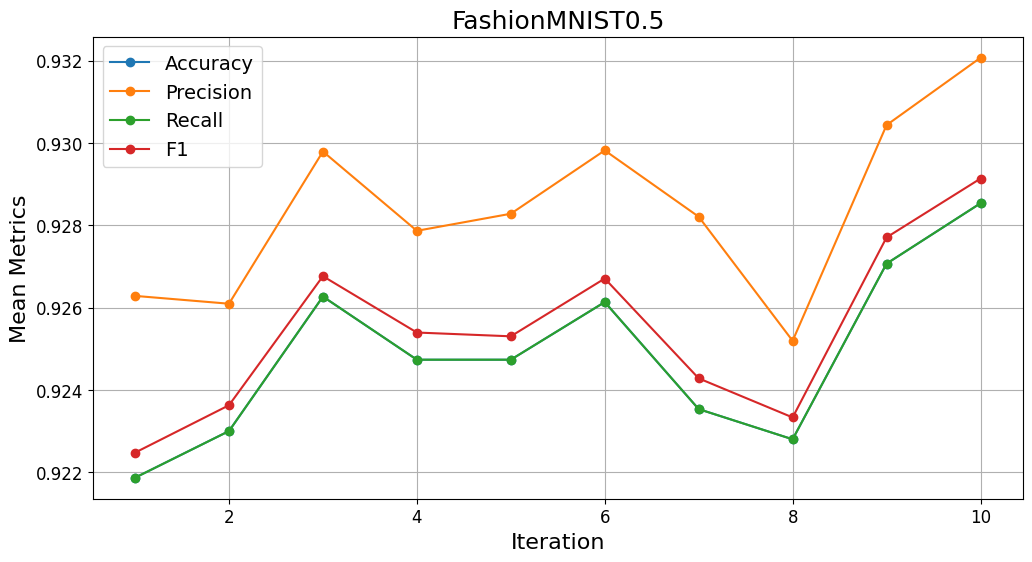

In [ ]:
baseline_acc_5 = 0.8
plt.figure(figsize=(12, 6))
for metric_name, metric_values in mean_metrics_f5.items():
    plt.plot(iterations, metric_values, marker='o', label=metric_name.capitalize())

# Add a horizontal line for the baseline
# plt.axhline(y=baseline_acc_5, color='r', linestyle='--', label='Baseline')

# Set the font sizes
label_fontsize = 16
title_fontsize = 18
legend_fontsize = 14

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Mean Metrics', fontsize=label_fontsize)
plt.title('FashionMNIST0.5', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
# Optionally, you can also increase the tick font sizes if needed
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


#### Experiment on FashionMNIST0.6

In [ ]:
seed_torch()
# Load and preprocess your data
with np.load('FashionMNIST0.6.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(Xtr_val, Str_val)
test_dataset = TensorDataset(Xts, Yts)

# Create DataLoaders for batching and shuffling the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the transition matrix for dealing with noisy labels
transition_matrix = torch.tensor([[0.4, 0.3, 0.3],
                                  [0.3, 0.4, 0.3],
                                  [0.3, 0.3, 0.4]], dtype=torch.float32)

# Train the model
num_epochs = 5

In [ ]:
n_iters = 10  # Set the number of iterations for the whole process
mean_metrics_f6 = defaultdict(list)

# Defining the device, and sending the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for n in range(n_iters):
    print(f"\nTraining iteration: {n+1}")

    # Reset the model and optimizer for each iteration
    model = FashionCNN(dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    all_metrics = defaultdict(list)  # Reset metrics for each iteration

    # Training and Testing loops for one iteration
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix, 0.95)
            loss.backward()
            optimizer.step()

        # Evaluation loop
        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  # No transition matrix applied during testing
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics at the end of each epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Store metrics
        all_metrics['accuracy'].append(accuracy)
        all_metrics['precision'].append(precision)
        all_metrics['recall'].append(recall)
        all_metrics['f1'].append(f1)

        # Print the metrics for the current epoch
        print(f'Epoch {epoch + 1}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}')

    # Calculate and store mean metrics for the current iteration
    for metric_name, metric_values in all_metrics.items():
        mean_metric = np.mean(metric_values)
        std_metric = np.std(metric_values)
        mean_metrics_f6[metric_name].append(mean_metric)
        print(f'Iteration {n+1} - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')




Training iteration: 1
Epoch 1: Accuracy = 0.8557, Precision = 0.8810, Recall = 0.8557, F1-Score = 0.8588


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8923, Precision = 0.9020, Recall = 0.8923, F1-Score = 0.8940


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.9050, Precision = 0.9084, Recall = 0.9050, F1-Score = 0.9059


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.9080, Precision = 0.9125, Recall = 0.9080, F1-Score = 0.9090


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.8947, Precision = 0.9073, Recall = 0.8947, F1-Score = 0.8953
Iteration 1 - Accuracy Mean: 0.8911, STD: 0.0187
Iteration 1 - Precision Mean: 0.9022, STD: 0.0111
Iteration 1 - Recall Mean: 0.8911, STD: 0.0187
Iteration 1 - F1 Mean: 0.8926, STD: 0.0179

Training iteration: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8443, Precision = 0.8857, Recall = 0.8443, F1-Score = 0.8475


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8687, Precision = 0.8939, Recall = 0.8687, F1-Score = 0.8711


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.9017, Precision = 0.9056, Recall = 0.9017, F1-Score = 0.9026


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.8883, Precision = 0.8942, Recall = 0.8883, F1-Score = 0.8887


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.9050, Precision = 0.9111, Recall = 0.9050, F1-Score = 0.9057
Iteration 2 - Accuracy Mean: 0.8816, STD: 0.0226
Iteration 2 - Precision Mean: 0.8981, STD: 0.0091
Iteration 2 - Recall Mean: 0.8816, STD: 0.0226
Iteration 2 - F1 Mean: 0.8831, STD: 0.0216

Training iteration: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8333, Precision = 0.8778, Recall = 0.8333, F1-Score = 0.8372


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8970, Precision = 0.8989, Recall = 0.8970, F1-Score = 0.8965


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8450, Precision = 0.8859, Recall = 0.8450, F1-Score = 0.8425


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.9120, Precision = 0.9168, Recall = 0.9120, F1-Score = 0.9127


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.8753, Precision = 0.8891, Recall = 0.8753, F1-Score = 0.8733
Iteration 3 - Accuracy Mean: 0.8725, STD: 0.0299
Iteration 3 - Precision Mean: 0.8937, STD: 0.0134
Iteration 3 - Recall Mean: 0.8725, STD: 0.0299
Iteration 3 - F1 Mean: 0.8724, STD: 0.0295

Training iteration: 4


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8663, Precision = 0.8945, Recall = 0.8663, F1-Score = 0.8679


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.9017, Precision = 0.9037, Recall = 0.9017, F1-Score = 0.9023


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.9050, Precision = 0.9107, Recall = 0.9050, F1-Score = 0.9060


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.9097, Precision = 0.9112, Recall = 0.9097, F1-Score = 0.9102


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.9030, Precision = 0.9119, Recall = 0.9030, F1-Score = 0.9036
Iteration 4 - Accuracy Mean: 0.8971, STD: 0.0156
Iteration 4 - Precision Mean: 0.9064, STD: 0.0066
Iteration 4 - Recall Mean: 0.8971, STD: 0.0156
Iteration 4 - F1 Mean: 0.8980, STD: 0.0153

Training iteration: 5


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.7480, Precision = 0.8216, Recall = 0.7480, F1-Score = 0.7206


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8813, Precision = 0.8902, Recall = 0.8813, F1-Score = 0.8822


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.9020, Precision = 0.9060, Recall = 0.9020, F1-Score = 0.9030


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.8703, Precision = 0.8827, Recall = 0.8703, F1-Score = 0.8720


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.9067, Precision = 0.9092, Recall = 0.9067, F1-Score = 0.9070
Iteration 5 - Accuracy Mean: 0.8617, STD: 0.0584
Iteration 5 - Precision Mean: 0.8819, STD: 0.0317
Iteration 5 - Recall Mean: 0.8617, STD: 0.0584
Iteration 5 - F1 Mean: 0.8570, STD: 0.0694

Training iteration: 6


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8637, Precision = 0.8843, Recall = 0.8637, F1-Score = 0.8663


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8940, Precision = 0.9063, Recall = 0.8940, F1-Score = 0.8951


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8503, Precision = 0.8926, Recall = 0.8503, F1-Score = 0.8490


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.8953, Precision = 0.9016, Recall = 0.8953, F1-Score = 0.8958


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.9053, Precision = 0.9081, Recall = 0.9053, F1-Score = 0.9060
Iteration 6 - Accuracy Mean: 0.8817, STD: 0.0210
Iteration 6 - Precision Mean: 0.8986, STD: 0.0090
Iteration 6 - Recall Mean: 0.8817, STD: 0.0210
Iteration 6 - F1 Mean: 0.8824, STD: 0.0213

Training iteration: 7


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8780, Precision = 0.8849, Recall = 0.8780, F1-Score = 0.8792


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.9033, Precision = 0.9076, Recall = 0.9033, F1-Score = 0.9038


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8607, Precision = 0.8815, Recall = 0.8607, F1-Score = 0.8593


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.9037, Precision = 0.9066, Recall = 0.9037, F1-Score = 0.9043


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.8603, Precision = 0.8865, Recall = 0.8603, F1-Score = 0.8634
Iteration 7 - Accuracy Mean: 0.8812, STD: 0.0193
Iteration 7 - Precision Mean: 0.8934, STD: 0.0113
Iteration 7 - Recall Mean: 0.8812, STD: 0.0193
Iteration 7 - F1 Mean: 0.8820, STD: 0.0192

Training iteration: 8


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8867, Precision = 0.8878, Recall = 0.8867, F1-Score = 0.8871


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.8797, Precision = 0.8899, Recall = 0.8797, F1-Score = 0.8813


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8943, Precision = 0.8974, Recall = 0.8943, F1-Score = 0.8950


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.8063, Precision = 0.8732, Recall = 0.8063, F1-Score = 0.8036


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.9073, Precision = 0.9143, Recall = 0.9073, F1-Score = 0.9083
Iteration 8 - Accuracy Mean: 0.8749, STD: 0.0355
Iteration 8 - Precision Mean: 0.8925, STD: 0.0134
Iteration 8 - Recall Mean: 0.8749, STD: 0.0355
Iteration 8 - F1 Mean: 0.8751, STD: 0.0369

Training iteration: 9


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8460, Precision = 0.8888, Recall = 0.8460, F1-Score = 0.8469


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.9060, Precision = 0.9086, Recall = 0.9060, F1-Score = 0.9067


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8990, Precision = 0.9118, Recall = 0.8990, F1-Score = 0.9001


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.8813, Precision = 0.9047, Recall = 0.8813, F1-Score = 0.8831


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.8220, Precision = 0.8793, Recall = 0.8220, F1-Score = 0.8203
Iteration 9 - Accuracy Mean: 0.8709, STD: 0.0321
Iteration 9 - Precision Mean: 0.8986, STD: 0.0125
Iteration 9 - Recall Mean: 0.8709, STD: 0.0321
Iteration 9 - F1 Mean: 0.8714, STD: 0.0329

Training iteration: 10


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Accuracy = 0.8613, Precision = 0.8781, Recall = 0.8613, F1-Score = 0.8638


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 2: Accuracy = 0.9017, Precision = 0.9120, Recall = 0.9017, F1-Score = 0.9020


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3: Accuracy = 0.8803, Precision = 0.9017, Recall = 0.8803, F1-Score = 0.8817


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 4: Accuracy = 0.7923, Precision = 0.8435, Recall = 0.7923, F1-Score = 0.7867


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 5: Accuracy = 0.8800, Precision = 0.8952, Recall = 0.8800, F1-Score = 0.8821
Iteration 10 - Accuracy Mean: 0.8631, STD: 0.0376
Iteration 10 - Precision Mean: 0.8861, STD: 0.0240
Iteration 10 - Recall Mean: 0.8631, STD: 0.0376
Iteration 10 - F1 Mean: 0.8633, STD: 0.0402


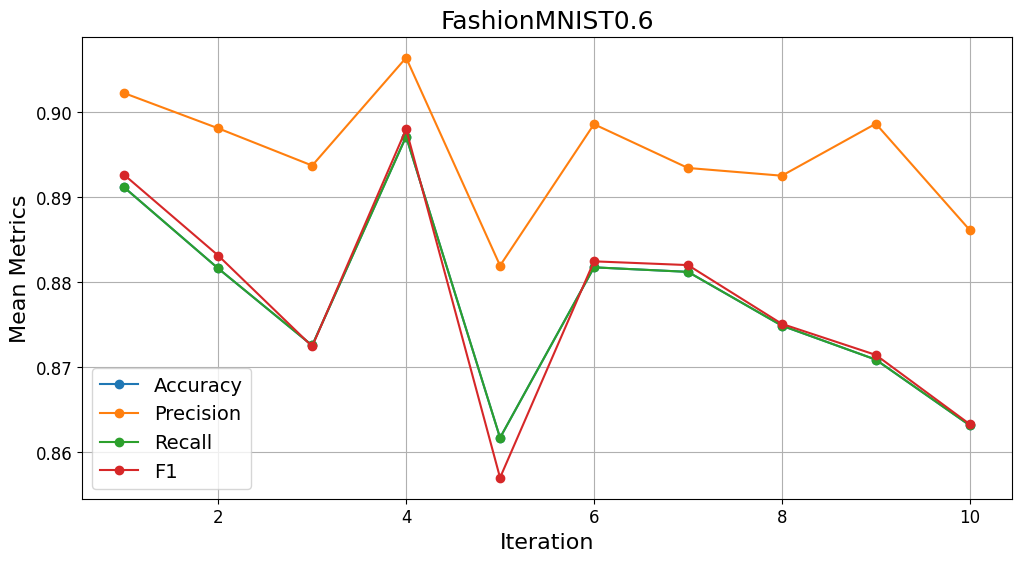

In [ ]:
baseline_acc_6 = 0.69  # Baseline accuracy

# After all iterations, plot the mean of the metrics
iterations = range(1, n_iters + 1)
plt.figure(figsize=(12, 6))
for metric_name, metric_values in mean_metrics_f6.items():
    plt.plot(iterations, metric_values, marker='o', label=metric_name.capitalize())

# Add a horizontal line for the baseline accuracy
# plt.axhline(y=baseline_acc_6, color='r', linestyle='--', label='Baseline Accuracy')

# Set the font sizes
label_fontsize = 16
title_fontsize = 18
legend_fontsize = 14

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Mean Metrics', fontsize=label_fontsize)
plt.title('FashionMNIST0.6', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Optionally, you can also increase the tick font sizes if needed
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


##3.3- Standard Deviation graph

In [ ]:
# Define the dictionaries and labels
mean_metrics_dicts = [mean_metrics_cifar, mean_metrics_f5, mean_metrics_f6]
labels = ['CIFAR', 'FashionMNIST0.5', 'FashionMNIST0.6']

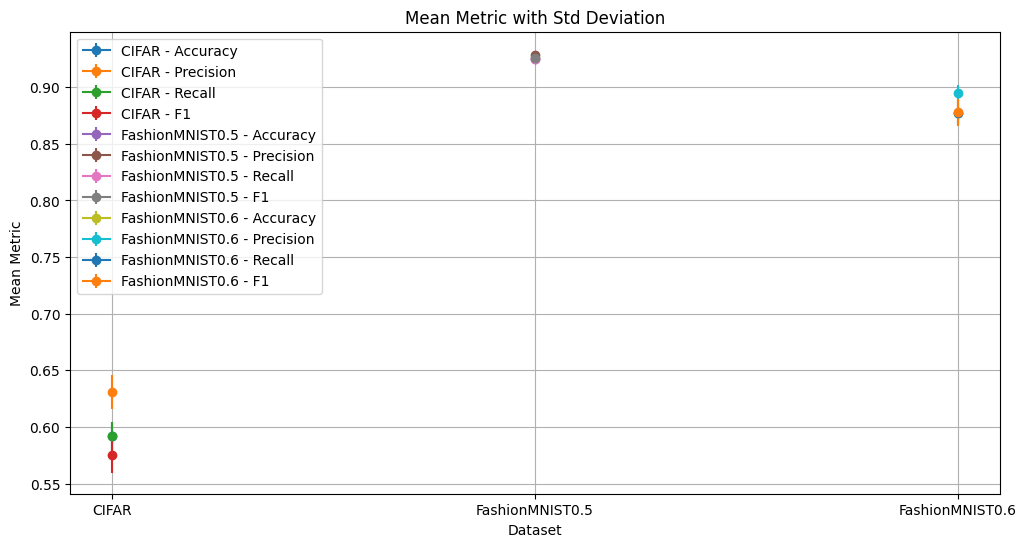

In [ ]:
plt.figure(figsize=(12, 6))


# Define larger font sizes for various elements
title_fontsize = 20
axis_label_fontsize = 18
ticks_fontsize = 16
annotation_fontsize = 14
legend_fontsize = 16

# Loop through the dictionaries and plot error bars for each metric
for mean_metrics, label in zip(mean_metrics_dicts, labels):
    for metric_name, metric_values in mean_metrics.items():
        std_metric = np.std(metric_values)
        mean_metric = np.mean(metric_values)
        plt.errorbar(label, mean_metric, yerr=std_metric, marker='o', label=f'{label} - {metric_name.capitalize()}')

# Set labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Metric')
plt.title('Mean Metric with Std Deviation')
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-54-9ce53ec87ce0>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(mean_metrics_dicts[0]))


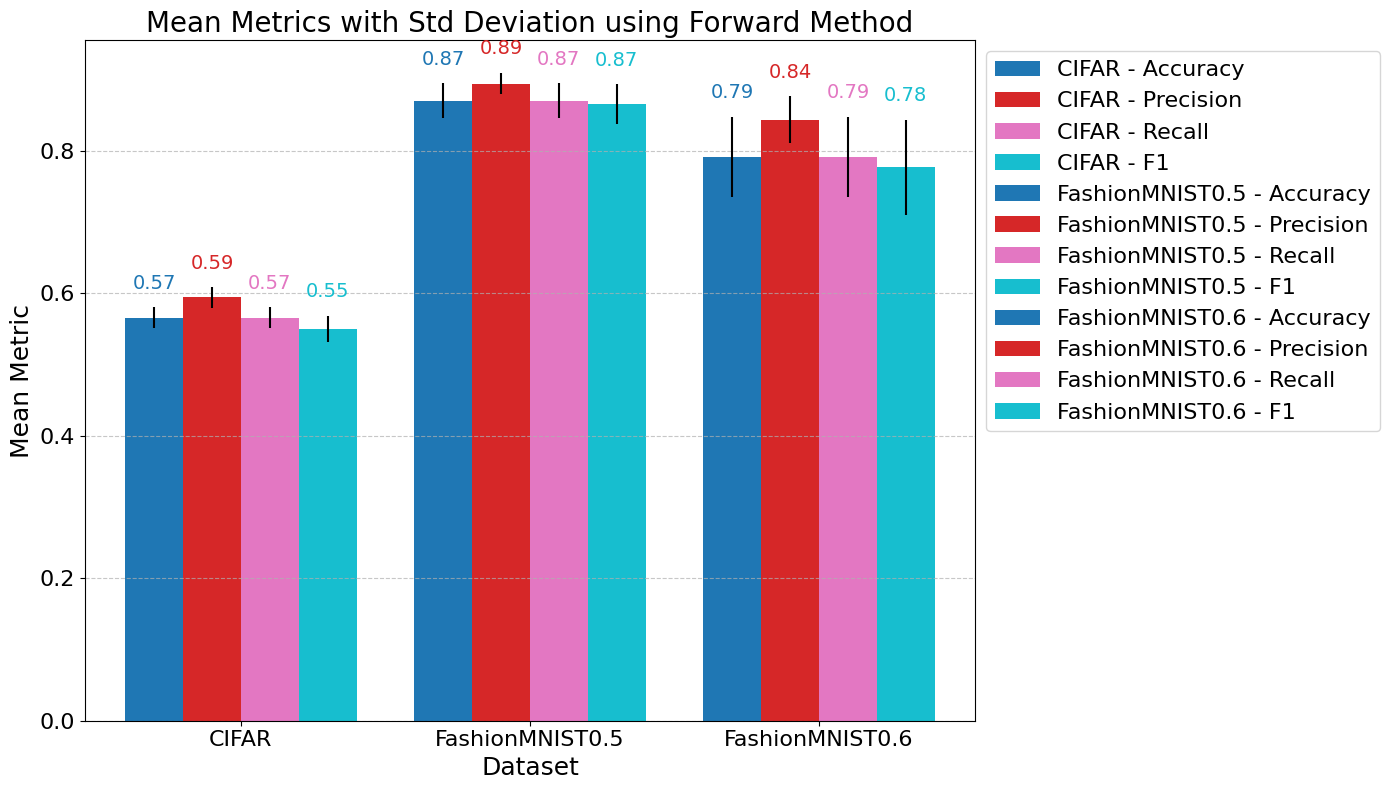

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a colormap for metrics
colormap = plt.cm.get_cmap('tab10', len(mean_metrics_dicts[0]))

plt.figure(figsize=(14, 8))
width = 0.2
x = np.arange(len(labels))

# Define larger font sizes for various elements
title_fontsize = 20
axis_label_fontsize = 18
ticks_fontsize = 16
annotation_fontsize = 14
legend_fontsize = 16

for i, (mean_metrics, label) in enumerate(zip(mean_metrics_dicts, labels)):
    for j, metric_name in enumerate(mean_metrics.keys()):
        mean_metric = np.mean(mean_metrics[metric_name])
        std_metric = np.std(mean_metrics[metric_name])
        color = colormap(j)  # Use colormap to get distinct colors
        plt.bar(x[i] + j * width, mean_metric, width, label=f'{label} - {metric_name.capitalize()}',
                yerr=std_metric, color=color)

        # Annotate the bar with numeric values
        plt.text(x[i] + j * width, mean_metric + std_metric + 0.02, f'{mean_metric:.2f}', ha='center', va='bottom', fontsize=annotation_fontsize, color=color)

# Set labels and title with increased font sizes
plt.xlabel('Dataset', fontsize=axis_label_fontsize)
plt.ylabel('Mean Metric', fontsize=axis_label_fontsize)
plt.title('Mean Metrics with Std Deviation using Forward Method', fontsize=title_fontsize)
plt.xticks(x + width * (len(mean_metrics_dicts[0]) - 1) / 2, labels, fontsize=ticks_fontsize)  # Use dataset labels as x-axis labels
plt.yticks(fontsize=ticks_fontsize)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=legend_fontsize)
plt.tight_layout()

# Show the plot with increased font sizes
plt.show()


##3.4 Tuning the hyper parameter for backward for three datasets

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):  # Default dropout rate
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Change here
            nn.BatchNorm2d(32),
            nn.ReLU(), #https://colab.research.google.com/drive/1LyTSETiFqX39hifMEnDwEmZY34AN-X6u#scrollTo=Tuning_the_hyper_parameter
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layers with dropout
        self.fc1 = nn.Linear(in_features=3136, out_features=600)
        self.drop = nn.Dropout2d(dropout_rate)  # Use the dropout rate parameter
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

with np.load('CIFAR.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)


# Convert tensors to numpy arrays for use with sklearn if they are not already
Xts_np = Xtr_val.numpy()
Yts_np = Str_val.numpy()

# Split the data into validation and test sets, with stratification to ensure class balance
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    Xts_np, Yts_np,
    test_size=1000,  # Leave 1000 samples for the validation set
    stratify=Yts_np,              # To maintain class distribution
    random_state=42               # For reproducibility
)

# Convert them back to tensors after the split
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
# Setting up data loaders

# Adjust the dimensions of image data
X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)
X_val_tensor = X_val_tensor.permute(0, 3, 1, 2)
# Define the transition matrix for dealing with noisy labels
num_epochs = 10

# Hyperparameters to tune
learning_rates = [ 0.0005, 0.0001, 0.00001, 0.00005, 0.000001]
batch_sizes = [16, 32, 64, 128]
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# Results dictionary for plotting
results = {}

# For tracking the best model
best_accuracy = 0
best_params = {}

# Define your model architecture

import random

# Instead of grid search, use random search
num_searches = 50  # Let's limit to 50 searches

for search in range(num_searches):
    # Randomly choose hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    ratio = random.choice(ratios)
    dropout_rate = random.choice(dropout_rates)

    print('new params', search, lr, batch_size, ratio, dropout_rate)
    # Create DataLoaders for batching
    train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor, y_train=y_train_tensor, X_test=X_val_tensor, y_test=y_val_tensor, batch_size=batch_size, transform=True)

    # Instantiate the model
    model = FashionCNN(dropout_rate=dropout_rate)

    # Move the model to the GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize a list to save accuracies for plotting
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Move tensors to the GPU if available
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Move tensors to the GPU if available
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)  # Save accuracy for plotting

        # print(f'Epoch [{epoch+1}/{num_epochs}], LR: {lr}, Batch Size: {batch_size}, GCE_ratio: {ratio}, Dropout Rate: {dropout_rate}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'gce_ratio': ratio,
                'dropout_rate': dropout_rate
            }
            best_model_state = model.state_dict().copy()

    # Store the accuracies in the results dictionary
    results[(lr, batch_size, ratio, dropout_rate)] = accuracies

# Print out the best hyperparameters and accuracy
print(f'Best parameters found:\n Learning Rate: {best_params["learning_rate"]}\n Batch Size: {best_params["batch_size"]}\n GCE ratio: {best_params["gce_ratio"]}\n Dropout Rate: {best_params["dropout_rate"]}\n Accuracy: {best_accuracy}')


new params 0 1e-05 16 0.5 0.3


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


new params 1 1e-05 128 0.9 0.4
new params 2 1e-05 128 0.1 0.4
new params 3 0.0001 16 0.5 0.1
new params 4 0.0005 64 0.3 0.1
new params 5 0.0001 64 0.9 0.3
new params 6 0.0001 32 0.3 0.5
new params 7 1e-05 16 0.5 0.3
new params 8 0.0005 16 0.1 0.2
new params 9 1e-05 16 0.1 0.1
new params 10 0.0005 16 0.3 0.3
new params 11 0.0001 64 0.3 0.1
new params 12 1e-06 128 0.3 0.1
new params 13 1e-06 128 0.9 0.1
new params 14 1e-05 128 0.3 0.4
new params 15 0.0005 64 0.5 0.1
new params 16 0.0001 16 0.1 0.1
new params 17 5e-05 128 0.3 0.2
new params 18 5e-05 16 0.7 0.3
new params 19 1e-06 64 0.5 0.3
new params 20 0.0005 64 0.1 0.2
new params 21 0.0001 128 0.7 0.3
new params 22 1e-06 16 0.5 0.3
new params 23 1e-05 64 0.1 0.4
new params 24 0.0001 32 0.3 0.2
new params 25 1e-06 32 0.3 0.2
new params 26 1e-05 64 0.1 0.4
new params 27 0.0005 32 0.7 0.5
new params 28 0.0005 128 0.9 0.5
new params 29 1e-05 64 0.1 0.1
new params 30 1e-06 16 0.3 0.4
new params 31 0.0001 32 0.7 0.2
new params 32 0.0005 64 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Default dropout rate
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # Apply Dropout with 0.25 probability
        self.drop = nn.Dropout2d(dropout_rate)
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # Fully Connected Layer 3
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out



# Load the FashionMNIST dataset with the same structure
with np.load('FashionMNIST0.5.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# The images are of shape (batch_size, 1, 28, 28), so no need for unsqueeze if the dataset is correctly formatted
# Adjust the dimensions of image data if needed
# Xtr_val = Xtr_val.permute(0, 3, 1, 2)
# Xts = Xts.permute(0, 3, 1, 2)

# Split the data into training and validation sets
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    Xtr_val.numpy(), Str_val.numpy(),
    test_size=1000,  # Reserve 1000 samples for the validation set
    stratify=Str_val.numpy(),
    random_state=42
)

# Convert back to tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long)

# If the original tensors are of shape [batch_size, height, width],
# we need to add a channel dimension before passing them into a CNN.
X_train_tensor = X_train_tensor.unsqueeze(1)  # This adds the channel dimension (becomes [batch_size, 1, height, width])
X_val_tensor = X_val_tensor.unsqueeze(1)

# Proceed with hyperparameter tuning as in the first code snippet
num_epochs = 10
learning_rates = [ 0.0005, 0.0001, 0.00001, 0.00005, 0.000001]
batch_sizes = [16, 32, 64, 128]
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
best_accuracy = 0
best_params = {}
num_searches = 50


for search in range(num_searches):
    # Randomly choose hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    ratio = random.choice(ratios)
    dropout_rate = random.choice(dropout_rates)

    print('new params', search, lr, batch_size, ratio, dropout_rate)
    # Create DataLoaders for batching
    train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor, y_train=y_train_tensor, X_test=X_val_tensor, y_test=y_val_tensor, batch_size=batch_size, transform=True)

    # Instantiate the model
    model = FashionCNN(dropout_rate=dropout_rate)

    # Move the model to the GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize a list to save accuracies for plotting
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Move tensors to the GPU if available
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Move tensors to the GPU if available
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)  # Save accuracy for plotting

        # print(f'Epoch [{epoch+1}/{num_epochs}], LR: {lr}, Batch Size: {batch_size}, GCE_ratio: {ratio}, Dropout Rate: {dropout_rate}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'gce_ratio': ratio,
                'dropout_rate': dropout_rate
            }
            best_model_state = model.state_dict().copy()

    # Store the accuracies in the results dictionary
    results[(lr, batch_size, ratio, dropout_rate)] = accuracies

# Print out the best hyperparameters and accuracy
print(f'Best parameters found:\n Learning Rate: {best_params["learning_rate"]}\n Batch Size: {best_params["batch_size"]}\n GCE ratio: {best_params["gce_ratio"]}\n Dropout Rate: {best_params["dropout_rate"]}\n Accuracy: {best_accuracy}')


new params 0 0.0001 64 0.5 0.3


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


new params 1 0.0001 32 0.7 0.4
new params 2 5e-05 32 0.5 0.4
new params 3 0.0005 16 0.9 0.4
new params 4 0.0005 32 0.7 0.5
new params 5 0.0005 32 0.5 0.1
new params 6 0.0001 16 0.9 0.3
new params 7 5e-05 16 0.9 0.5
new params 8 0.0001 32 0.7 0.5
new params 9 1e-06 64 0.9 0.2
new params 10 5e-05 128 0.7 0.3
new params 11 1e-06 32 0.1 0.1
new params 12 1e-06 16 0.3 0.4
new params 13 1e-06 64 0.9 0.5
new params 14 0.0005 16 0.3 0.3
new params 15 1e-05 32 0.9 0.2
new params 16 5e-05 32 0.5 0.2
new params 17 1e-06 128 0.3 0.4
new params 18 0.0005 128 0.5 0.5
new params 19 1e-05 16 0.5 0.5
new params 20 5e-05 64 0.1 0.4
new params 21 0.0001 128 0.1 0.1
new params 22 5e-05 128 0.3 0.2
new params 23 0.0001 128 0.9 0.2
new params 24 0.0005 64 0.7 0.4
new params 25 1e-06 16 0.1 0.2
new params 26 0.0005 16 0.3 0.2
new params 27 0.0005 32 0.9 0.4
new params 28 5e-05 64 0.7 0.5
new params 29 5e-05 64 0.3 0.2
new params 30 5e-05 64 0.5 0.5
new params 31 1e-05 32 0.5 0.5
new params 32 0.0001 32 0.3 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Default dropout rate
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # Apply Dropout with 0.25 probability
        self.drop = nn.Dropout2d(dropout_rate)
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # Fully Connected Layer 3
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out



# Load the FashionMNIST dataset with the same structure
with np.load('FashionMNIST0.6.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# The images are of shape (batch_size, 1, 28, 28), so no need for unsqueeze if the dataset is correctly formatted
# Adjust the dimensions of image data if needed
# Xtr_val = Xtr_val.permute(0, 3, 1, 2)
# Xts = Xts.permute(0, 3, 1, 2)

# Split the data into training and validation sets
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    Xtr_val.numpy(), Str_val.numpy(),
    test_size=1000,  # Reserve 1000 samples for the validation set
    stratify=Str_val.numpy(),
    random_state=42
)

# Convert back to tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long)

# If the original tensors are of shape [batch_size, height, width],
# we need to add a channel dimension before passing them into a CNN.
X_train_tensor = X_train_tensor.unsqueeze(1)  # This adds the channel dimension (becomes [batch_size, 1, height, width])
X_val_tensor = X_val_tensor.unsqueeze(1)

# Proceed with hyperparameter tuning as in the first code snippet
num_epochs = 10
learning_rates = [ 0.0005, 0.0001, 0.00001, 0.00005, 0.000001]
batch_sizes = [16, 32, 64, 128]
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
best_accuracy = 0
best_params = {}
num_searches = 50


for search in range(num_searches):
    # Randomly choose hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    ratio = random.choice(ratios)
    dropout_rate = random.choice(dropout_rates)

    print('new params', search, lr, batch_size, ratio, dropout_rate)
    # Create DataLoaders for batching
    train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor, y_train=y_train_tensor, X_test=X_val_tensor, y_test=y_val_tensor, batch_size=batch_size, transform=True)

    # Instantiate the model
    model = FashionCNN(dropout_rate=dropout_rate)

    # Move the model to the GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize a list to save accuracies for plotting
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Move tensors to the GPU if available
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = corrected_loss(outputs, labels, transition_matrix)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Move tensors to the GPU if available
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)  # Save accuracy for plotting

        # print(f'Epoch [{epoch+1}/{num_epochs}], LR: {lr}, Batch Size: {batch_size}, GCE_ratio: {ratio}, Dropout Rate: {dropout_rate}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'gce_ratio': ratio,
                'dropout_rate': dropout_rate
            }
            best_model_state = model.state_dict().copy()

    # Store the accuracies in the results dictionary
    results[(lr, batch_size, ratio, dropout_rate)] = accuracies

# Print out the best hyperparameters and accuracy
print(f'Best parameters found:\n Learning Rate: {best_params["learning_rate"]}\n Batch Size: {best_params["batch_size"]}\n GCE ratio: {best_params["gce_ratio"]}\n Dropout Rate: {best_params["dropout_rate"]}\n Accuracy: {best_accuracy}')


new params 0 1e-06 32 0.9 0.2


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


new params 1 0.0001 64 0.9 0.5
new params 2 0.0001 16 0.7 0.5
new params 3 1e-05 16 0.5 0.1
new params 4 1e-05 64 0.5 0.3
new params 5 0.0005 32 0.9 0.5
new params 6 0.0005 64 0.1 0.5
new params 7 1e-06 128 0.1 0.4
new params 8 5e-05 64 0.9 0.5
new params 9 1e-05 128 0.3 0.3
new params 10 5e-05 32 0.1 0.1
new params 11 1e-06 128 0.1 0.1
new params 12 1e-05 32 0.3 0.3
new params 13 0.0001 32 0.9 0.2
new params 14 0.0005 32 0.9 0.4
new params 15 1e-06 16 0.1 0.5
new params 16 5e-05 64 0.9 0.4
new params 17 0.0001 128 0.9 0.3
new params 18 5e-05 32 0.3 0.5
new params 19 5e-05 32 0.7 0.4
new params 20 0.0001 64 0.7 0.1
new params 21 0.0005 16 0.5 0.4
new params 22 1e-06 32 0.9 0.2
new params 23 1e-05 128 0.5 0.4
new params 24 1e-05 64 0.1 0.4
new params 25 1e-06 16 0.9 0.1
new params 26 1e-05 16 0.5 0.3
new params 27 0.0005 128 0.1 0.1
new params 28 0.0005 128 0.9 0.4
new params 29 1e-05 128 0.5 0.4
new params 30 1e-05 128 0.5 0.3
new params 31 0.0001 16 0.5 0.4
new params 32 0.0005 16 0.9

#4- Importance Reweighting with ResNet


##4.1- Defining Resnet Model


In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    Implements the Residual Block of the ResNet architecture.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = self.conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = self.conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    @staticmethod
    def conv3x3(in_channels, out_channels, stride=1):
        """
        Returns a 3x3 convolution with padding.
        """
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    """
    Implements the ResNet architecture.
    """
    def __init__(self, block, layers, num_channels=1, num_filter=7, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 16

        # Initial Convolution
        self.conv = self.conv3x3(num_channels, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # Residual Layers
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)

        # Fully connected layers
        self.avg_pool = nn.AvgPool2d(num_filter)
        self.fc = nn.Linear(64, num_classes)
        self.delta_T = nn.Linear(num_classes, num_classes, False)

        # Initialize delta_T weights to zero
        nn.init.zeros_(self.delta_T.weight)

    @staticmethod
    def conv3x3(in_channels, out_channels, stride=1):
        """
        Returns a 3x3 convolution with padding.
        """
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                self.conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, revision=False, plot_deltaT=False):
        correction = self.delta_T.weight
        if plot_deltaT:
            print("Corr", correction)
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        if revision:
            return out, correction
        return out

##4.2- Defining Reweighting Loss Function

In [ ]:
import torch
import torch.nn.functional as F

class ReweightingLoss(torch.nn.Module):
    """
    Implements a custom loss that reweights the standard cross-entropy loss
    based on a given transformation matrix T and the target labels.
    """

    def __init__(self):
        super(ReweightingLoss, self).__init__()

    def forward(self, predictions, transformation_matrix, target):
        """
        Compute the reweighted loss.

        Args:
        - predictions (torch.Tensor): The model's raw output (logits).
        - transformation_matrix (torch.Tensor): The given transformation matrix T.
        - target (torch.Tensor): The ground-truth labels.

        Returns:
        - torch.Tensor: The computed reweighted loss.
        """

        # Compute softmax of the predictions
        softmax_predictions = F.softmax(predictions, dim=1)

        # Gather the probabilities corresponding to the true labels
        true_label_probs = softmax_predictions.gather(1, target.view(-1, 1))

        # Apply the transformation matrix on the softmax predictions
        transformed_probs = torch.mm(transformation_matrix.t(), softmax_predictions.t())
        transformed_true_label_probs = transformed_probs.t().gather(1, target.view(-1, 1))

        # Compute the reweighting factor (beta)
        beta = torch.nn.Parameter(true_label_probs / transformed_true_label_probs)

        # Compute the standard cross-entropy loss without reduction
        standard_loss = F.cross_entropy(predictions, target, reduction='none')

        # Apply the reweighting factor on the standard loss
        reweighted_loss = beta.view(1, -1) * standard_loss

        return torch.mean(reweighted_loss)


### Experiment on FashionMNIST0.6


(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)
Fold 1/10
Epoch 0/9
----------
train Loss: 0.6473 Acc: 0.3743
val Loss: 0.3714 Acc: 0.3608

Epoch 1/9
----------
train Loss: 0.4372 Acc: 0.3889
val Loss: 0.4167 Acc: 0.3911

Epoch 2/9
----------
train Loss: 0.4321 Acc: 0.3892
val Loss: 0.3931 Acc: 0.3764

Epoch 3/9
----------
train Loss: 0.3831 Acc: 0.3950
val Loss: 0.3465 Acc: 0.3931

Epoch 4/9
----------
train Loss: 0.3362 Acc: 0.3951
val Loss: 0.2855 Acc: 0.3903

Epoch 5/9
----------
train Loss: 0.3425 Acc: 0.3958
val Loss: 0.3689 Acc: 0.3775

Epoch 6/9
----------
train Loss: 0.3022 Acc: 0.3977
val Loss: 0.2366 Acc: 0.3847

Epoch 7/9
----------
train Loss: 0.3100 Acc: 0.3944
val Loss: 0.3097 Acc: 0.3883

Epoch 8/9
----------
train Loss: 0.3024 Acc: 0.3992
val Loss: 0.3557 Acc: 0.3767

Epoch 9/9
----------
train Loss: 0.2965 Acc: 0.3998
val Loss: 0.2893 Acc: 0.3803

Best val Acc: 0.393056
Fold 1 Test Set Metrics:
Accuracy: 0.8727
Precision: 0.8801
Recall: 0.8727
F1-Score: 0.8740
Fold 2/

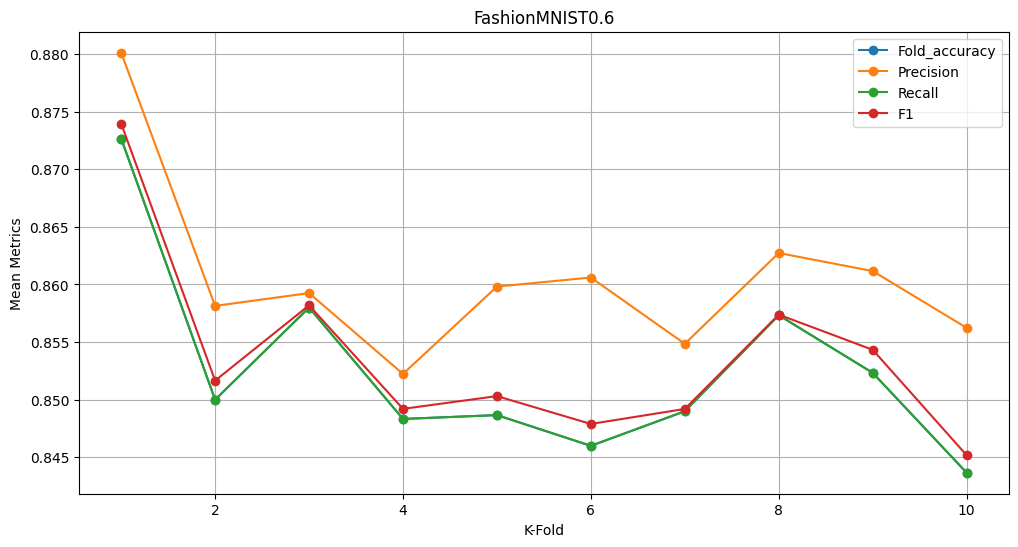

In [ ]:
import numpy as np
import torch
from torch import optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

dataset = np.load('FashionMNIST0.6.npz')
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)

X_train = dataset['Xtr']/255
y_train = dataset['Str']
X_test = dataset['Xts']/255
y_test = dataset['Yts']



if X_train.ndim == 4:
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

elif X_train.ndim == 3:
  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor,
                                                   y_train=y_train_tensor,
                                                   X_test=X_test_tensor,
                                                   y_test=y_test_tensor,
                                                   batch_size=128,
                                                   transform = True
                                                   )

dataloaders_dict = {'train': train_loader, 'val': val_loader}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize K-Fold cross-validation
num_folds = 10
seed_torch()
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize the KFold_f6 dictionary to store metrics
KFold_f6 = {'fold_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    # Define the model for this fold
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], num_channels=1).to(device)

    # Define optimizer and loss function
    optimizer_ft = optim.Adam(model_modified_resnet.parameters(), lr=0.001)
    criterion = ReweightingLoss()
    T_matrix = torch.tensor([[0.4, 0.3, 0.3],
                             [0.3, 0.4, 0.3],
                             [0.3, 0.3, 0.4]], device=device)

    # Train the model for this fold
    model_modified_resnet, _, _ = train_model_forward(
        model_modified_resnet,
        dataloaders_dict,
        criterion,
        optimizer_ft,
        T_matrix,
        num_epochs=10
    )

   # Evaluate the model on the test set for this fold
    model_modified_resnet.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_modified_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    fold_accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    # Print metrics for this fold
    print(f'Fold {fold + 1} Test Set Metrics:')
    print(f'Accuracy: {fold_accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Store metrics for this fold in KFold_f6 dictionary
    KFold_f6['fold_accuracy'].append(fold_accuracy)
    KFold_f6['precision'].append(precision)
    KFold_f6['recall'].append(recall)
    KFold_f6['f1'].append(f1)

# Calculate and store mean metrics for all folds in KFold_f6
for metric_name, metric_values in KFold_f6.items():
    mean_metric = np.mean(metric_values)
    std_metric = np.std(metric_values)
    print(f'All Folds - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')

# Plot the mean metrics over all folds
kfold = range(1, num_folds + 1)
plt.figure(figsize=(12, 6))
for metric_name, metric_values in KFold_f6.items():
    plt.plot(kfold, metric_values, marker='o', label=metric_name.capitalize())

plt.xlabel('K-Fold')
plt.ylabel('Mean Metrics')
plt.title('FashionMNIST0.6')
plt.legend()
plt.grid(True)
plt.show()

### Experiment on FashionMNIST0.5

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)
Fold 1/10
Epoch 0/9
----------
train Loss: 0.6783 Acc: 0.4556
val Loss: 0.5794 Acc: 0.4658

Epoch 1/9
----------
train Loss: 0.6611 Acc: 0.4744
val Loss: 0.6182 Acc: 0.4642

Epoch 2/9
----------
train Loss: 0.6379 Acc: 0.4792
val Loss: 0.6701 Acc: 0.4675

Epoch 3/9
----------
train Loss: 0.6444 Acc: 0.4789
val Loss: 0.5130 Acc: 0.4781

Epoch 4/9
----------
train Loss: 0.6422 Acc: 0.4813
val Loss: 0.6401 Acc: 0.4739

Epoch 5/9
----------
train Loss: 0.6313 Acc: 0.4841
val Loss: 0.5852 Acc: 0.4758

Epoch 6/9
----------
train Loss: 0.6250 Acc: 0.4842
val Loss: 0.6732 Acc: 0.4783

Epoch 7/9
----------
train Loss: 0.6293 Acc: 0.4862
val Loss: 0.5643 Acc: 0.4794

Epoch 8/9
----------
train Loss: 0.6170 Acc: 0.4895
val Loss: 0.6562 Acc: 0.4828

Epoch 9/9
----------
train Loss: 0.6125 Acc: 0.4883
val Loss: 0.5702 Acc: 0.4794

Best val Acc: 0.482778
Fold 1 Test Set Metrics:
Accuracy: 0.9133
Precision: 0.9204
Recall: 0.9133
F1-Score: 0.9135
Fold 2/

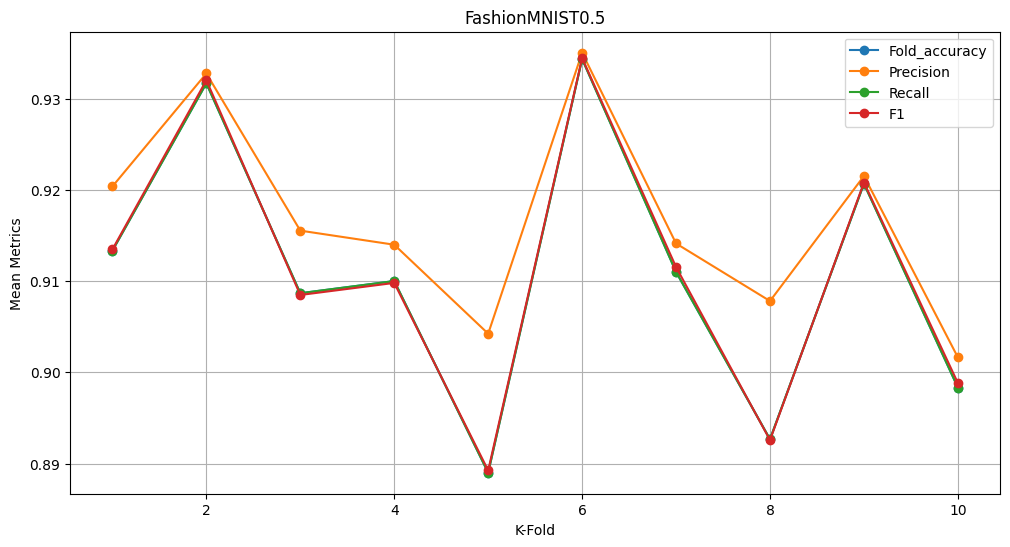

In [ ]:
dataset = np.load('FashionMNIST0.5.npz')
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)

X_train = dataset['Xtr']/255
y_train = dataset['Str']
X_test = dataset['Xts']/255
y_test = dataset['Yts']


if X_train.ndim == 4:
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

elif X_train.ndim == 3:
  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor,
                                                   y_train=y_train_tensor,
                                                   X_test=X_test_tensor,
                                                   y_test=y_test_tensor,
                                                   batch_size=128,
                                                   transform = True
                                                   )


dataloaders_dict = {'train': train_loader, 'val': val_loader}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize K-Fold cross-validation
num_folds = 10
seed_torch()
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize the KFold_f5 dictionary to store metrics
KFold_f5 = {'fold_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]

    # Define the model for this fold
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], num_channels=1).to(device)

    # Define optimizer and loss function
    optimizer_ft = optim.Adam(model_modified_resnet.parameters(), lr=0.001)
    criterion = ReweightingLoss()
    T_matrix = torch.tensor([[0.5, 0.2, 0.3],
                             [0.3, 0.5, 0.2],
                             [0.2, 0.3, 0.5]], device=device)

    # Train the model for this fold
    model_modified_resnet, _, _ = train_model_forward(
        model_modified_resnet,
        dataloaders_dict,
        criterion,
        optimizer_ft,
        T_matrix,
        num_epochs=10
    )

   # Evaluate the model on the test set for this fold
    model_modified_resnet.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_modified_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    fold_accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    # Print metrics for this fold
    print(f'Fold {fold + 1} Test Set Metrics:')
    print(f'Accuracy: {fold_accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Store metrics for this fold in KFold_f5 dictionary
    KFold_f5['fold_accuracy'].append(fold_accuracy)
    KFold_f5['precision'].append(precision)
    KFold_f5['recall'].append(recall)
    KFold_f5['f1'].append(f1)

# Calculate and store mean metrics for all folds in KFold_f5
for metric_name, metric_values in KFold_f5.items():
    mean_metric = np.mean(metric_values)
    std_metric = np.std(metric_values)
    print(f'All Folds - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')

# Plot the mean metrics over all folds
kfold = range(1, num_folds + 1)
plt.figure(figsize=(12, 6))
for metric_name, metric_values in KFold_f5.items():
    plt.plot(kfold, metric_values, marker='o', label=metric_name.capitalize())

plt.xlabel('K-Fold')
plt.ylabel('Mean Metrics')
plt.title('FashionMNIST0.5')
plt.legend()
plt.grid(True)
plt.show()

### Experiment on CIFAR




In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

(15000, 32, 32, 3)
(15000,)
(3000, 32, 32, 3)
(3000,)
Fold 1/10
Epoch 0/9
----------
train Loss: 1.0238 Acc: 0.3574
val Loss: 1.0029 Acc: 0.3747

Epoch 1/9
----------
train Loss: 1.0279 Acc: 0.3715
val Loss: 0.9820 Acc: 0.3670

Epoch 2/9
----------
train Loss: 1.0236 Acc: 0.3822
val Loss: 1.0406 Acc: 0.3717

Epoch 3/9
----------
train Loss: 1.0208 Acc: 0.3816
val Loss: 1.0202 Acc: 0.3730

Epoch 4/9
----------
train Loss: 1.0183 Acc: 0.3917
val Loss: 0.9690 Acc: 0.3773

Epoch 5/9
----------
train Loss: 1.0079 Acc: 0.3952
val Loss: 1.0026 Acc: 0.3723

Epoch 6/9
----------
train Loss: 1.0102 Acc: 0.4052
val Loss: 1.0025 Acc: 0.3653

Epoch 7/9
----------
train Loss: 1.0004 Acc: 0.4071
val Loss: 1.0608 Acc: 0.3677

Epoch 8/9
----------
train Loss: 0.9919 Acc: 0.4152
val Loss: 0.9787 Acc: 0.3623

Epoch 9/9
----------
train Loss: 0.9812 Acc: 0.4255
val Loss: 1.0366 Acc: 0.3530

Best val Acc: 0.377333
Fold 1 Test Set Metrics:
Accuracy: 0.3613
Precision: 0.7538
Recall: 0.3613
F1-Score: 0.2224
F

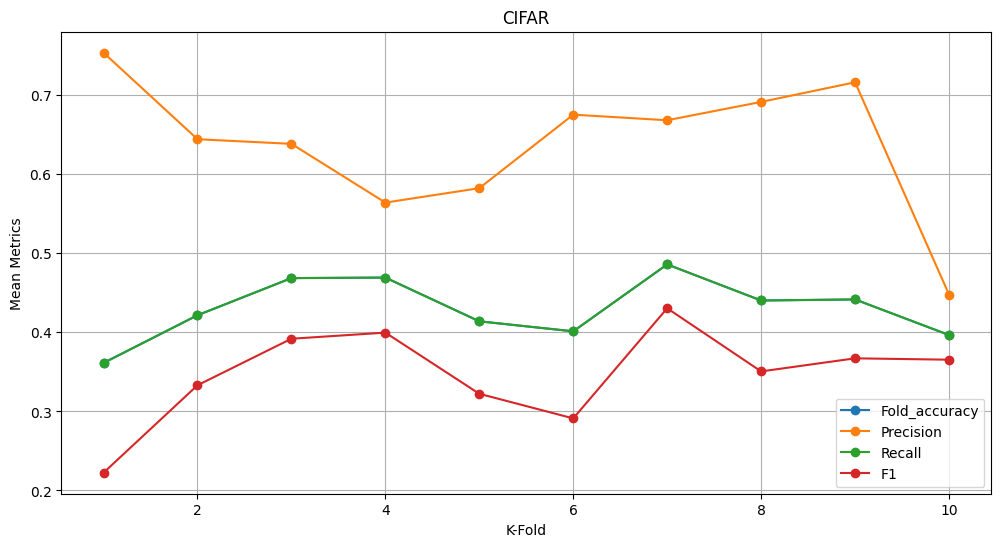

In [ ]:
dataset = np.load('CIFAR.npz')
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)

X_train = dataset['Xtr']/255
y_train = dataset['Str']
X_test = dataset['Xts']/255
y_test = dataset['Yts']


if X_train.ndim == 4:
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

elif X_train.ndim == 3:
  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]
  X_train = np.rollaxis(X_train, 3, 1)
  X_test = np.rollaxis(X_test, 3, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader, val_loader, test_loader = get_loader(X_train=X_train_tensor,
                                                   y_train=y_train_tensor,
                                                   X_test=X_test_tensor,
                                                   y_test=y_test_tensor,
                                                   batch_size=128,
                                                   transform = True
                                                   )


dataloaders_dict = {'train': train_loader, 'val': val_loader}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize K-Fold cross-validation
num_folds = 10
seed_torch()
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize the KFold_cifar dictionary to store metrics
KFold_cifar = {'fold_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]

    # Define the model for this fold
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], num_channels=3).to(device)  # Set num_channels to 1

    # Define optimizer and loss function
    optimizer_ft = optim.Adam(model_modified_resnet.parameters(), lr=0.001)
    criterion = ReweightingLoss()
    T_matrix = torch.tensor([[0.7945, 0.0527, 0.1528],
                             [0.1472, 0.6585, 0.1943],
                             [0.0799, 0.0359, 0.8842]], device=device)

    # Train the model for this fold
    model_modified_resnet, _, _ = train_model_forward(
        model_modified_resnet,
        dataloaders_dict,
        criterion,
        optimizer_ft,
        T_matrix,
        num_epochs=10
    )

   # Evaluate the model on the test set for this fold
    model_modified_resnet.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_modified_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    fold_accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    # Print metrics for this fold
    print(f'Fold {fold + 1} Test Set Metrics:')
    print(f'Accuracy: {fold_accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Store metrics for this fold in KFold_cifar dictionary
    KFold_cifar['fold_accuracy'].append(fold_accuracy)
    KFold_cifar['precision'].append(precision)
    KFold_cifar['recall'].append(recall)
    KFold_cifar['f1'].append(f1)

# Calculate and store mean metrics for all folds in KFold_cifar
for metric_name, metric_values in KFold_cifar.items():
    mean_metric = np.mean(metric_values)
    std_metric = np.std(metric_values)
    print(f'All Folds - {metric_name.capitalize()} Mean: {mean_metric:.4f}, STD: {std_metric:.4f}')

# Plot the mean metrics over all folds
kfold = range(1, num_folds + 1)
plt.figure(figsize=(12, 6))
for metric_name, metric_values in KFold_cifar.items():
    plt.plot(kfold, metric_values, marker='o', label=metric_name.capitalize())

plt.xlabel('K-Fold')
plt.ylabel('Mean Metrics')
plt.title('CIFAR')
plt.legend()
plt.grid(True)
plt.show()

##4.3- Standard Deviation graph

In [ ]:
# Define the dictionaries and labels
reweight_dicts = [KFold_cifar, KFold_f5, KFold_f6]
labels = ['CIFAR', 'FashionMNIST0.5', 'FashionMNIST0.6']

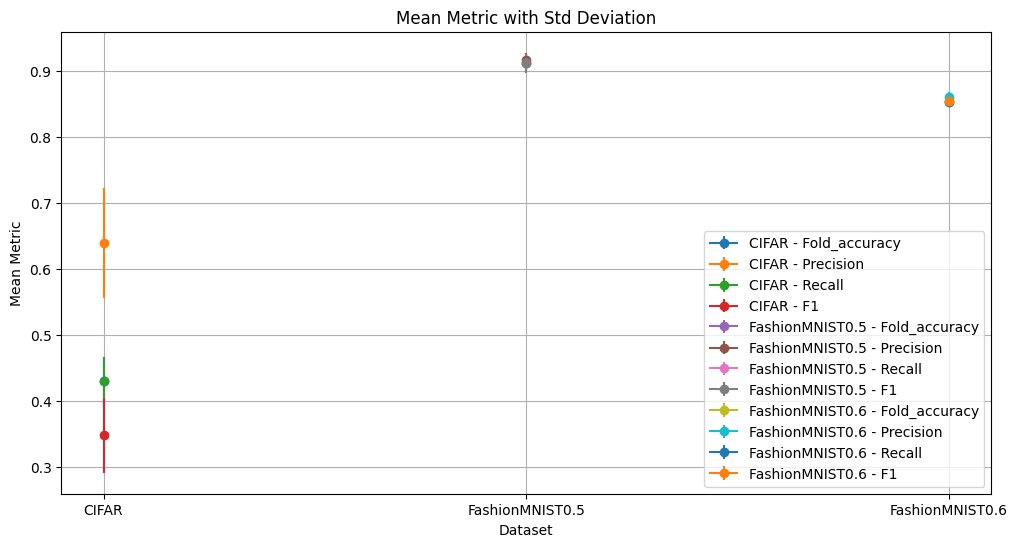

In [ ]:
plt.figure(figsize=(12, 6))


# Define larger font sizes for various elements
title_fontsize = 20
axis_label_fontsize = 18
ticks_fontsize = 16
annotation_fontsize = 14
legend_fontsize = 16

# Loop through the dictionaries and plot error bars for each metric
for mean_metrics, label in zip(reweight_dicts, labels):
    for metric_name, metric_values in mean_metrics.items():
        std_metric = np.std(metric_values)
        mean_metric = np.mean(metric_values)
        plt.errorbar(label, mean_metric, yerr=std_metric, marker='o', label=f'{label} - {metric_name.capitalize()}')

# Set labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Metric')
plt.title('Mean Metric with Std Deviation')
plt.grid(True)
plt.legend()
plt.show()


#5.- Baseline models: CNN without application of noisy label correction methods

I will first use a CNN to train the two FashionMNIST dataset. Then I adjust the input layer of the model to train on the CIFAR dataset.

The purpose of baseline model is to make comparison of performances of different model before and after applying corrected loss function and transition matrix into training process of classifiers with noisy label data.



In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # Change here
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layer 1
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # Apply Dropout with 0.25 probability
        self.drop = nn.Dropout2d(0.25)
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # Fully Connected Layer 3
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
seed_torch()
with np.load('FashionMNIST0.5.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(Xtr_val, Str_val)
test_dataset = TensorDataset(Xts, Yts)

# Create DataLoaders for batching and shuffling the data
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100)


# Instantiate the model, and define the loss function and optimizer
model = FashionCNN()
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate the model, and define the loss function and optimizer
model = FashionCNN()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Testing the model
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Calculate and print the classification report
from sklearn.metrics import classification_report, confusion_matrix

predictions = []
true_labels = []
for images, labels_batch in test_loader:
    images, labels_batch = images.to(device), labels_batch.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels_batch.cpu().numpy())

print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/5], Step [100/180], Loss: 1.0203
Epoch [2/5], Step [100/180], Loss: 1.0593
Epoch [3/5], Step [100/180], Loss: 1.0866
Epoch [4/5], Step [100/180], Loss: 1.0334
Epoch [5/5], Step [100/180], Loss: 1.0848
Test Accuracy of the model on the test images: 90.66666666666667 %
[[838 100  62]
 [  2 950  48]
 [ 49  19 932]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1000
           1       0.89      0.95      0.92      1000
           2       0.89      0.93      0.91      1000

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [ ]:
seed_torch()
# Load and preprocess FashionMNIST0.6
with np.load('FashionMNIST0.6.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Ensure the data has the correct shape
if len(Xtr_val.shape) == 3:
    Xtr_val = Xtr_val.unsqueeze(1)  # Add a channel dimension
if len(Xts.shape) == 3:
    Xts = Xts.unsqueeze(1)

# Setting up data loaders
train_loader, val_loader, test_loader = get_loader(X_train=Xtr_val, y_train=Str_val, X_test=Xts, y_test=Yts, batch_size=128, transform=True)
data_loaders_dict = {'train': train_loader, 'val': val_loader}


# Instantiate the model, and define the loss function and optimizer
model = FashionCNN()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Testing the model
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Calculate and print the classification report
from sklearn.metrics import classification_report, confusion_matrix

predictions = []
true_labels = []
for images, labels_batch in test_loader:
    images, labels_batch = images.to(device), labels_batch.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels_batch.cpu().numpy())

print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/5], Step [100/113], Loss: 1.0873
Epoch [2/5], Step [100/113], Loss: 1.1010
Epoch [3/5], Step [100/113], Loss: 1.0882
Epoch [4/5], Step [100/113], Loss: 1.1030
Epoch [5/5], Step [100/113], Loss: 1.0994
Test Accuracy of the model on the test images: 70.73333333333333 %
[[500   0 500]
 [  9 626 365]
 [  3   1 996]]
              precision    recall  f1-score   support

           0       0.98      0.50      0.66      1000
           1       1.00      0.63      0.77      1000
           2       0.54      1.00      0.70      1000

    accuracy                           0.71      3000
   macro avg       0.84      0.71      0.71      3000
weighted avg       0.84      0.71      0.71      3000



In [ ]:
# Define the CNN model for Cifar dataset
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Layer 1: Convolution Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Change here
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 2: Convolution Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully Connected Layer 1
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=3136, out_features=600)
        # Apply Dropout with 0.25 probability
        self.drop = nn.Dropout2d(0.25)
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # Fully Connected Layer 3
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
seed_torch()
# Load and preprocess your data
with np.load('CIFAR.npz') as data_total:
    Xtr_val = torch.tensor(data_total['Xtr'], dtype=torch.float32)
    Str_val = torch.tensor(data_total['Str'], dtype=torch.long)
    Xts = torch.tensor(data_total['Xts'], dtype=torch.float32)
    Yts = torch.tensor(data_total['Yts'], dtype=torch.long)

# Adjust the dimensions of image data
Xtr_val = Xtr_val.permute(0, 3, 1, 2)
Xts = Xts.permute(0, 3, 1, 2)

# Setting up data loaders
train_loader, val_loader, test_loader = get_loader(X_train=Xtr_val, y_train=Str_val, X_test=Xts, y_test=Yts, batch_size=128, transform=True)
data_loaders_dict = {'train': train_loader, 'val': val_loader}

# Instantiate the model, and define the loss function and optimizer
model = FashionCNN()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Testing the model
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Calculate and print the classification report
from sklearn.metrics import classification_report, confusion_matrix

predictions = []
true_labels = []
for images, labels_batch in test_loader:
    images, labels_batch = images.to(device), labels_batch.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels_batch.cpu().numpy())

print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Accuracy of the model on the test images: 52.93333333333333 %
[[617 215 168]
 [171 513 316]
 [266 276 458]]
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1000
           1       0.51      0.51      0.51      1000
           2       0.49      0.46      0.47      1000

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.53      0.53      3000

